# Tier Analysis
## Figure 5 (a)

# Setting up paths

In [1]:
import sys
from pathlib import Path
#Set root to be the main project folder
#Note that this notebook is in /SOCIAL_DISTANCING/CODE/NOTEBOOKS/TEST_NOTEBOOKS
root = Path.cwd().parent.parent
print(root)
py_path = Path(root/'code/py-files')
print(py_path)
data_path = Path(root/'static')
print(data_path)
#Add location of py files to path so we can import
sys.path.insert(0,str(py_path))

/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final
/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final/code/py-files
/home/gnacikm/Documents/GitHub/cvals_new/BSIRS_final/static


In [2]:
%matplotlib notebook 

# Importing Libraries

In [3]:
import os
from datetime import datetime
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from importlib import reload
from tqdm import tqdm
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.patches as mpatches
from kneed import KneeLocator
import exposure_matrix as mat
import execute_system as exe_sys
import plotting
from helper_fun import finding_best
%matplotlib inline

## Imporing Files

In [4]:
utla_folder = Path(data_path/'utla_data/')

In [5]:
gdf_covid =  gpd.read_file(utla_folder/"shp/covid-cases_EN_recent.shp")
df_pops = pd.read_csv(utla_folder/'csv/population.csv')

In [6]:
gdf_utla_tiers = gpd.read_file(utla_folder/"shp/UTLA_tiers.shp")

In [9]:
def read_file_u(lam_val, beta_val):
    df_uvals= pd.read_csv(data_path/f"saved_params/u_vals/u_vals_beta_{beta_val}_lam_{lam_val}.csv")
    u_vals = df_uvals.values.transpose()
    return u_vals 

# Tier maps

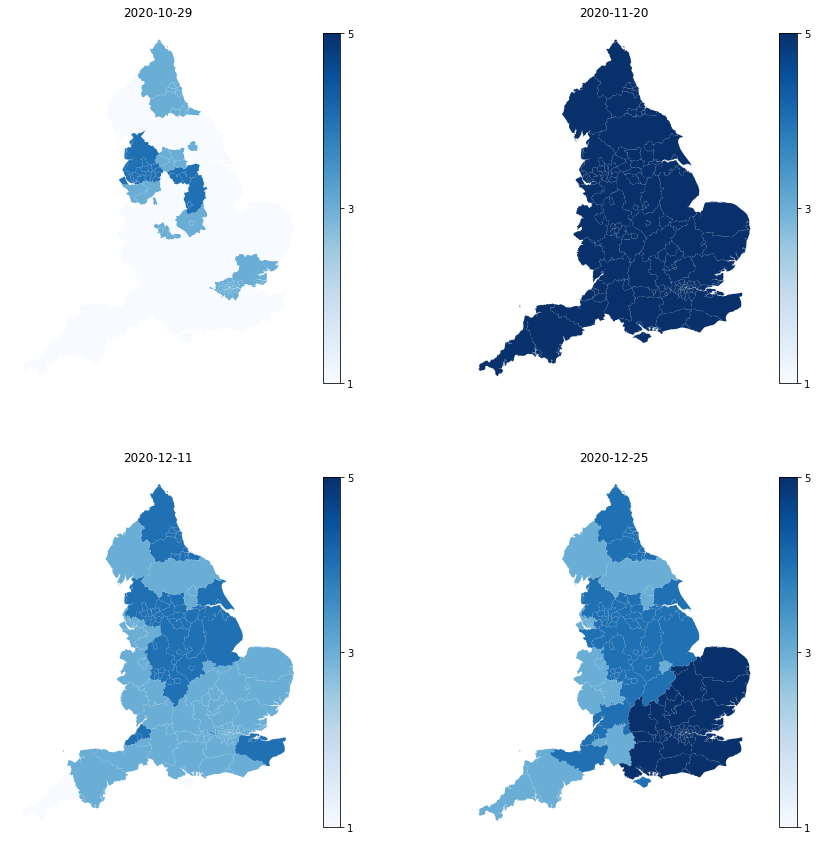

In [11]:
nrows = 2
ncols = 2
seldates = ["2020-10-29", "2020-11-20", "2020-12-11","2020-12-25"]
fig, axes = plt.subplots(nrows = nrows, ncols= ncols, figsize=(15,15))
l = 0
for j in range(nrows):
    for k in range(ncols):
        gdf_utla_tiers.plot(seldates[l], cmap="Blues", figsize=(10,10), ax=axes[j][k], rasterized=True,vmax=5.0, vmin=1.0 )
        axes[j][k].set_title(seldates[l])
        l+=1
        cbar = fig.colorbar(cm.ScalarMappable(cmap="Blues"), ax=axes[j][k], fraction=0.046, pad=0.04)
        cbar.set_ticks([0, 0.5, 1.0])
        cbar.set_ticklabels([1, 3, 5])
        axes[j][k].axis('off')
plt.savefig(data_path/f"saved_figures/alert_levels.pdf",  dpi=200, bbox_inches = 'tight')        
plt.show()

## Preparing data

In [12]:
datetime_object = datetime.strptime("2020-09-29", '%Y-%m-%d')
datetime_object 

datetime.datetime(2020, 9, 29, 0, 0)

In [13]:
dates = ['2020-10-12', '2020-10-16', '2020-10-22', '2020-10-23',
       '2020-10-27', '2020-10-29', '2020-10-30', '2020-11-04',
       '2020-11-12', '2020-11-13', '2020-11-20', '2020-11-23',
       '2020-11-24', '2020-12-01', '2020-12-11', '2020-12-15',
       '2020-12-18']#, '2020-12-20', '2020-12-25']

In [14]:
start = datetime.strptime("2020-09-29", '%Y-%m-%d')
days_to_con = np.empty_like(dates, dtype="int")
for k,date in enumerate(dates):
    dat = datetime.strptime(date, '%Y-%m-%d')
    days = (dat-start).days
    days_to_con[k]=days

In [15]:
beta_val = 0.5
lam_val = 2.0
u_vals = read_file_u(lam_val, beta_val)

In [16]:
u_selected = u_vals[:,days_to_con]

# Tier whisker Plot

In [17]:
total_tiers = []
for date in dates:
    single_tier = []
    for tier in np.arange(1., 6.):
        single_tier.append(np.where(gdf_utla_tiers[date]==tier)[0])
    total_tiers.append(single_tier)

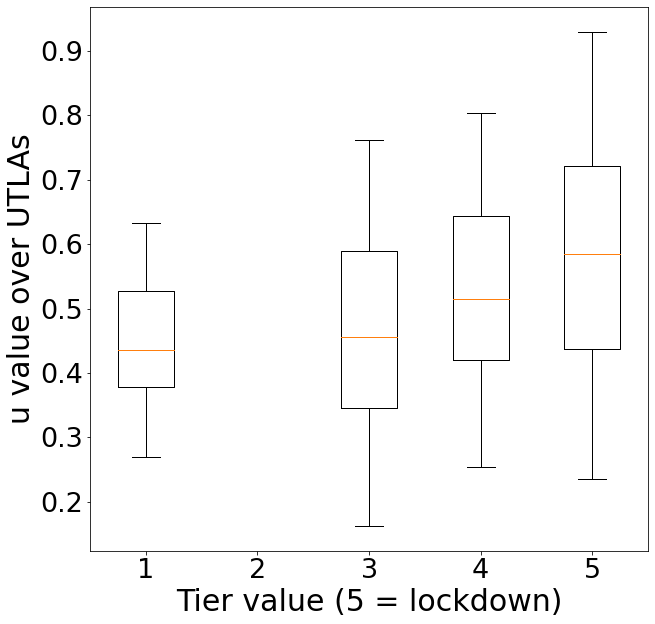

In [18]:
#fig1, ax1 = plt.subplots()
tiers = 5
tiers_arr = [[float(1+k)] for k in range(tiers)]
plt.figure(figsize=(10,10))
B = plt.boxplot(
    [np.concatenate([u_selected[total_tiers[j][k]][:, j] for j in range(len(dates))]) for k in range(tiers)],
    notch=False,  showfliers=False, whis=0.75 )
plt.ylabel(f"u value over UTLAs", fontsize=30)
plt.xlabel(r"Tier value (5 = lockdown)", fontsize=30)
plt.yticks(fontsize=27)
plt.xticks(fontsize=27)
plt.savefig(data_path/f"saved_figures/whisker_plot_u_vs_tier.pdf")
plt.show()

In [19]:
tiers = [np.concatenate([u_selected[total_tiers[j][k]][:, j] for j in range(len(dates))]) for k in range(tiers)]

In [20]:
df = pd.DataFrame()
medians = []
stds = []
quantile = []
quantile1 = []
for k in range(5):
    if len(tiers[k])>0:
        medians.append(np.median(tiers[k]))
        stds.append(tiers[k].std())
        quantile.append(np.quantile(tiers[k], 0.75))
        quantile1.append(np.quantile(tiers[k], 0.25))

In [21]:
mins = []
maxs = []
for k in range(10):
    data = [item.get_ydata() for item in B['whiskers']][k][1]
    if not np.isnan(data):
        if k%2!=0:
            maxs.append(data)
        else:
            mins.append(data)

In [22]:
df["tier"] = [1,3,4,5]
df["median"] = medians
df["standard dev"] = stds
df["min whisk"] = mins
df["max whisk"] = maxs
df["0.75 quantile"] = quantile
df["0.25 quantile"] = quantile1

In [23]:
df

,tier,median,standard dev,min whisk,max whisk,0.75 quantile,0.25 quantile
0,1,0.435932,0.132667,0.269148,0.632844,0.527144,0.378835
1,3,0.455186,0.167100,0.162326,0.762249,0.589252,0.345239
2,4,0.514890,0.152179,0.254329,0.803663,0.643248,0.420678
3,5,0.585077,0.184443,0.236099,0.929260,0.720445,0.437711
